In [2]:

#dog breed indentifier using CNN
# Importing the libraries
import tensorflow as tf


# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# print(gpu_devices)

# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# This disables the GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except e:
    # Invalid device or cannot modify virtual devices once initialized.
    print(e)
    pass

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import cv2
import random
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy


2022-12-15 09:46:31.031619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 09:46:31.978855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/corey/miniconda3/envs/tf/lib/:/home/corey/miniconda3/envs/tf/lib/
2022-12-15 09:46:31.978903: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/corey/miniconda3/envs/tf/lib/:/home/corey/minicond

In [3]:
RESULTS_DIR = './results/'
IMG_SIZE = 224

BATCH_SIZE_PRE = 32
BATCH_SIZE_FINE = 32
EPOCHS_PRE = 10
EPOCHS_FINE = 12
MOMENTUM = 0.9

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 10,
    horizontal_flip = True,
    validation_split = 0.2)

train_pre_generator = train_datagen.flow_from_directory(
    directory = "./data/fusion/train/",
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = "rgb",
    batch_size = BATCH_SIZE_PRE,
    class_mode = "categorical")

train_fine_generator = train_datagen.flow_from_directory(
    directory = "./data/fusion/train/",
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = "rgb",
    batch_size = BATCH_SIZE_FINE,
    class_mode = "categorical")

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)
test_generator = test_datagen.flow_from_directory(
    directory = "./data/fusion/test/",
    batch_size = BATCH_SIZE_FINE,
    class_mode = "categorical"
)


Found 18680 images belonging to 172 classes.
Found 18680 images belonging to 172 classes.
Found 9355 images belonging to 172 classes.


In [5]:
assert len(os.listdir('./data/fusion/train/')) == len(os.listdir('./data/fusion/test/'))
num_breeds = len(os.listdir('./data/fusion/train/')) - 1
print("num_breeds:", num_breeds)

num_breeds: 172


In [6]:
nasnetmobile_base_model = NASNetMobile(include_top=False,
                                        weights='imagenet',
                                        input_shape=(IMG_SIZE,IMG_SIZE,3))

x_base_nasnetmobile = nasnetmobile_base_model.output
x_avg_pooling_nasnetmobile = GlobalAveragePooling2D()(x_base_nasnetmobile)
x_first_fc_nasnetmobile = Dense(1024, activation='relu')(x_avg_pooling_nasnetmobile)
x_last_fc_nasnetmobile = Dense(num_breeds, activation='softmax')(x_first_fc_nasnetmobile)

nasnetmobile_custom_model = Model(inputs=nasnetmobile_base_model.inputs, outputs=x_last_fc_nasnetmobile)

nasnetmobile_custom_model.summary()

2022-12-15 09:46:34.202664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                             

                                                                                                  
 separable_conv_1_pad_reduction  (None, 115, 115, 32  0          ['activation_7[0][0]']           
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_9 (Activation)      (None, 56, 56, 11)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 56, 56, 11)  44          ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add (Add)                      (None, 56, 56, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 56, 56, 11)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d (Cropping2D)        (None, 111, 111, 32  0           ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 61, 61, 22)  0           ['activation_16[0][0]']          
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_18 (Activation)     (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 28, 28, 22)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 28, 28, 22)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 57, 57, 44)  0           ['adjust_relu_1_0[0][0]']        
 D)                                                                                               
          

 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_24 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 28, 28, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_33 (Activation)     (None, 28, 28, 88)   0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_34 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_0[0][0]']        
          

 separable_conv_2_normal_left2_  (None, 28, 28, 44)  3036        ['activation_40[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 44)  2332        ['activation_42[0][0]']          
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 44)  2332        ['activation_44[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (Bat

 activation_55 (Activation)     (None, 28, 28, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 44)  3036        ['activation_47[0][0]']          
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 44)  2332        ['activation_49[0][0]']          
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 28, 28, 44)  3036        ['activation_51[0][0]']          
 2 (SeparableConv2D)                                                                              
          

 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
                                                                                                  
 normal_add_2_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 2_2[0][0]',                      
          

 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_60 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activation_62 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_3[0][0]']                     
                                                                                                  
 activation_64 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_3[0][0]']                      
          

 activation_70 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_69 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction_conv_1_reduce_4 (Con  (None, 28, 28, 88)  23232       ['activation_70[0][0]']          
 v2D)                                                                                             
                                                                                                  
 adjust_conv_projection_reduce_  (None, 28, 28, 88)  23232       ['activation_69[0][0]']          
 4 (Conv2D)                                                                                       
                                                                                                  
 reduction

                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 14, 14, 88)  9944        ['separable_conv_1_pad_reduction_
 ht3_reduce_4 (SeparableConv2D)                                  right3_reduce_4[0][0]']          
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 88)  8536        ['activation_79[0][0]']          
 t4_reduce

                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2d_2 (Cropping2D)      (None, 28, 28, 264)  0           ['zero_padding2d_2[0][0]']       
                                                                                                  
 reduction_concat_reduce_4 (Con  (None, 14, 14, 352)  0          ['reduction_add_2_reduce_4[0][0]'
 catenate)                                                       , 'reduction_add3_reduce_4[0][0]'
                                                                 , 'add_2[0][0]',                 
                                                                  'reduction_add4_reduce_4[0][0]']
          

                                                                                                  
 activation_89 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_5[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_83[0][0]']          
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 adjust_bn_6 (BatchNormalizatio  (None, 14, 14, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 14, 14, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_94 (Activation)     (None, 14, 14, 88)   0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 activation_96 (Activation)     (None, 14, 14, 88)   0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activatio

 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 normal_left3_6 (AveragePooling  (None, 14, 14, 88)  0           ['normal_bn_1_6[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_6 (AveragePooling  (None, 14, 14, 88)  0           ['adjust_bn_6[0][0]']            
 2D)                                                                                              
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_1_normal_right1_
 ht1_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left2_7
 t2_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 normal_add_4_7 (Add)           (None, 14, 14, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 14, 14, 88)   0           ['separable_conv_2_bn_normal_left
                                                                 5_7[0][0]',                      
                                                                  'normal_bn_1_7[0][0]']          
                                                                                                  
 normal_concat_7 (Concatenate)  (None, 14, 14, 528)  0           ['adjust_bn_7[0][0]',            
                                                                  'normal_add_1_7[0][0]',         
                                                                  'normal_add_2_7[0][0]',         
          

                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_119[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 88)  8536        ['activation_121[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 88)  9944        ['activation_123[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 activation_130 (Activation)    (None, 14, 14, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_132 (Activation)    (None, 14, 14, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable_conv_1_pad_reduction  (None, 17, 17, 176)  0          ['activation_130[0][0]']         
 _left1_reduce_8 (ZeroPadding2D                                                                   
 )                                                                                                
                                                                                                  
 separable_conv_1_pad_reduction  (None, 19, 19, 176)  0          ['activation_132[0][0]']         
 _right1_reduce_8 (ZeroPadding2                                                                   
 D)       

 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_left
 left4_reduce_8 (BatchNormaliza                                  4_reduce_8[0][0]']               
 tion)                                                                                            
                                                                                                  
 reduction_pad_1_reduce_8 (Zero  (None, 15, 15, 176)  0          ['reduction_bn_1_reduce_8[0][0]']
 Padding2D)                                                                                       
                                                                                                  
 separable

                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
                                                                                                  
 activation_140 (Activation)    (None, 7, 7, 704)    0           ['reduction_concat_reduce_8[0][0]
                                                                 ']                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 7, 7, 176)    0           ['adjust_conv_1_9[0][0]',        
                                                                  'adjust_conv_2_9[0][0]']        
          

 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_148[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_150[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (Ba

 separable_conv_1_normal_left1_  (None, 7, 7, 176)   35376       ['activation_153[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 7, 7, 176)   32560       ['activation_155[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 7, 7, 176)   35376       ['activation_157[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 7, 7, 176)   32560       ['activation_159[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_add_1_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
          

 activation_166 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_168 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_170 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_172 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
          

 activation_176 (Activation)    (None, 7, 7, 1056)   0           ['normal_concat_11[0][0]']       
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 7, 7, 176)   185856      ['activation_175[0][0]']         
 v2D)                                                                                             
                                                                                                  
 normal_conv_1_12 (Conv2D)      (None, 7, 7, 176)    185856      ['activation_176[0][0]']         
                                                                                                  
 adjust_bn_12 (BatchNormalizati  (None, 7, 7, 176)   704         ['adjust_conv_projection_12[0][0]
 on)                                                             ']                               
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left2_1
 t2_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (B

In [8]:
#Train model - freeze body layers first
for layer in nasnetmobile_base_model.layers:
    layer.trainable = False

nasnetmobile_custom_model.compile(optimizer=SGD(momentum=MOMENTUM), loss=categorical_crossentropy, metrics=['accuracy'])

model_train_pre = nasnetmobile_custom_model.fit_generator(
    generator = train_pre_generator,
    steps_per_epoch = (train_pre_generator.n//train_pre_generator.batch_size),
    epochs = EPOCHS_PRE,
    validation_data = test_generator,
    validation_steps = (test_generator.n//test_generator.batch_size),
    verbose=1
)

nasnetmobile_custom_model.save(os.path.join(RESULTS_DIR, 'model_pre_nasnetm_4.h5'))

/tmp/ipykernel_369205/527160221.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_train_pre = nasnetmobile_custom_model.fit_generator(


Epoch 1/10
583/583 [==============================] - 338s 571ms/step - loss: 0.6714 - accuracy: 0.7917 - val_loss: 0.7189 - val_accuracy: 0.7969
Epoch 2/10
583/583 [==============================] - 337s 578ms/step - loss: 0.6056 - accuracy: 0.8051 - val_loss: 0.6828 - val_accuracy: 0.8095
Epoch 3/10
583/583 [==============================] - 332s 570ms/step - loss: 0.5582 - accuracy: 0.8201 - val_loss: 0.6917 - val_accuracy: 0.8070
Epoch 4/10
583/583 [==============================] - 338s 580ms/step - loss: 0.5179 - accuracy: 0.8290 - val_loss: 0.6773 - val_accuracy: 0.8101
Epoch 5/10
583/583 [==============================] - 337s 577ms/step - loss: 0.4817 - accuracy: 0.8408 - val_loss: 0.6673 - val_accuracy: 0.8104
Epoch 6/10
583/583 [==============================] - 333s 571ms/step - loss: 0.4437 - accuracy: 0.8486 - val_loss: 0.6759 - val_accuracy: 0.8051
Epoch 7/10
583/583 [==============================] - 337s 577ms/step - loss: 0.4167 - accuracy: 0.8582 - val_loss: 0.6692 -

In [14]:
#Train model - train all layers
for layer in nasnetmobile_base_model.layers:
    layer.trainable = True
    
nasnetmobile_custom_model.compile(optimizer=SGD(momentum=MOMENTUM), loss=categorical_crossentropy, metrics=['accuracy'] )

model_train_fine = nasnetmobile_custom_model.fit_generator(
    generator = train_fine_generator,
    steps_per_epoch = (train_fine_generator.n//train_fine_generator.batch_size),
    epochs = EPOCHS_FINE,
    validation_data = test_generator,
    validation_steps = (test_generator.n//test_generator.batch_size),
    verbose = 1
)

nasnetmobile_custom_model.save(os.path.join(RESULTS_DIR, 'model_fine_nasnetm_2.h5'))

/tmp/ipykernel_359351/738299973.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_train_fine = nasnetmobile_custom_model.fit_generator(


Epoch 1/12
583/583 [==============================] - 1065s 2s/step - loss: 1.4879 - accuracy: 0.5785 - val_loss: 4.0172 - val_accuracy: 0.1415
Epoch 2/12
583/583 [==============================] - 1045s 2s/step - loss: 1.0001 - accuracy: 0.6960 - val_loss: 3.2852 - val_accuracy: 0.2521
Epoch 3/12
583/583 [==============================] - 1045s 2s/step - loss: 0.8071 - accuracy: 0.7455 - val_loss: 3.4898 - val_accuracy: 0.2308
Epoch 4/12
583/583 [==============================] - 1046s 2s/step - loss: 0.6637 - accuracy: 0.7891 - val_loss: 3.3886 - val_accuracy: 0.2414
Epoch 5/12
583/583 [==============================] - 1046s 2s/step - loss: 0.5473 - accuracy: 0.8214 - val_loss: 2.8758 - val_accuracy: 0.3243
Epoch 6/12
583/583 [==============================] - 1045s 2s/step - loss: 0.4652 - accuracy: 0.8496 - val_loss: 2.6710 - val_accuracy: 0.3561
Epoch 7/12
583/583 [==============================] - 1042s 2s/step - loss: 0.3868 - accuracy: 0.8749 - val_loss: 2.9753 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

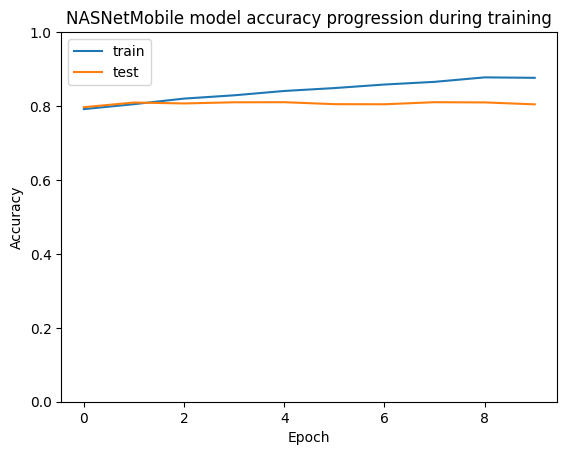

In [10]:
# Display progress of model training

plt.plot(model_train_pre.history['accuracy'])
plt.plot(model_train_pre.history['val_accuracy'])
plt.title('NASNetMobile model accuracy progression during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0.0, 1.0)
plt.show